In [262]:
from sklearn.ensemble import RandomForestClassifier as rf
from kdg.utils import generate_gaussian_parity, plot_2dsim
from tqdm import tqdm
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import colorbar

In [397]:
X, y = generate_gaussian_parity(1000)
X_ood, y_ood = generate_gaussian_parity(1000, angle_params=np.pi/4)

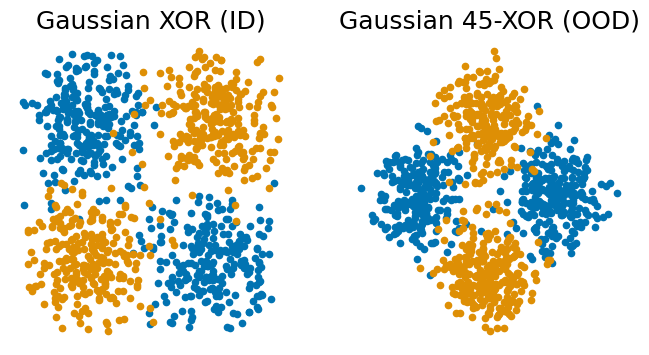

In [412]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

plot_2dsim(X,y, ax=ax[0])
plot_2dsim(X_ood,y_ood, ax=ax[1])

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)
left_side = ax[0].spines["left"]
left_side.set_visible(False)
bottom_side = ax[0].spines["bottom"]
bottom_side.set_visible(False)


right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)
left_side = ax[1].spines["left"]
left_side.set_visible(False)
bottom_side = ax[1].spines["bottom"]
bottom_side.set_visible(False)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].set_title('Gaussian XOR (ID)')
ax[1].set_title(r'Gaussian 45-XOR (OOD)')

plt.savefig('simulation.pdf')

In [411]:
n_estimators = 500
n_seeds = 100
splitting_criteria = ['gini', 'entropy', 'log_loss']
n_criteria = len(splitting_criteria)
n_train_id = 1000
n_test_id = 1000
n_eval_ood = 1000
n_test_ood = 1000
angles = [0, np.pi/8, np.pi/4, np.pi/2]

In [212]:
def experiment(angle, n_components, stress=False):
    rf_models = [[] for _ in range(n_criteria)]

    x_train_id, y_train_id = generate_gaussian_parity(n_train_id)
    x_test_id, y_test_id = generate_gaussian_parity(n_test_id)
    
    x_eval_ood, y_eval_ood = generate_gaussian_parity(n_eval_ood, angle_params=angle)
    x_test_ood, y_test_ood = generate_gaussian_parity(n_test_ood, angle_params=angle)
    
    for i in range(n_criteria):
        for j in range(n_seeds):
            model = rf(n_estimators=n_estimators, criterion=splitting_criteria[i], random_state=(j+1)*(i+1))
            model.fit(x_train_id, y_train_id)
            rf_models[i].append(model)

    ##########################################################
    l_id = np.zeros((n_criteria, n_seeds), dtype=float)
    l_ood = np.zeros((n_criteria, n_seeds), dtype=float)
    proba = []
    
    for i in (range(n_criteria)):
        for j in range(n_seeds):
            proba.append(
                rf_models[i][j].predict_proba(x_eval_ood)
            )
            y_pred_id = rf_models[i][j].predict(x_test_id)
            y_pred_ood = rf_models[i][j].predict(x_test_ood)
            l_id[i,j] = 1 - np.mean(y_test_id==y_pred_id)
            l_ood[i,j] = 1 - np.mean(y_test_ood==y_pred_ood)

    ########################################################
    D = np.zeros((n_seeds*n_criteria, n_seeds*n_criteria), dtype=float)

    for ii in range(n_seeds*n_criteria):
        for jj in range(ii+1, n_seeds*n_criteria):
            D[ii,jj] = np.sum((proba[ii]-proba[jj])**2)**.5
            D[jj,ii] = D[ii,jj]

    #######################################################

    embedding = MDS(n_components=n_components, dissimilarity='precomputed')
    X_transformed = embedding.fit_transform(D)

    if stress:
        return X_transformed, l_id, l_ood, embedding.stress_
    else:
        return X_transformed, l_id, l_ood

In [210]:
def plot_embeddings(X_transformed, l_id, l_ood, angle, ax):
    ax.scatter(X_transformed[:100,0], X_transformed[:100,1], l_ood[0], c='k', marker='o', alpha=(l_id[0]-np.min(l_id[0]))/(np.max(l_id[0])-np.min(l_id[0])), label=splitting_criteria[0], s=40)
    ax.scatter(X_transformed[100:200,0], X_transformed[100:200,1], l_ood[1], c='r', marker='o', alpha=(l_id[1]-np.min(l_id[1]))/(np.max(l_id[1])-np.min(l_id[1])), label=splitting_criteria[1], s=40)
    ax.scatter(X_transformed[200:,0], X_transformed[200:,1], l_ood[2], c='b', marker='o', alpha=(l_id[2]-np.min(l_id[2]))/(np.max(l_id[2])-np.min(l_id[2])), label=splitting_criteria[2], s=40)

    ax.set_zlabel('l_ood')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.set_title('angle ' + str(np.round(angle*180/np.pi,1)))
    ax.set_xticks([-0.5,0,0.5])
    ax.set_yticks([-0.5,0,0.5])
    

In [206]:
X_transformed, l_id, l_ood = [], [], []
for angle in tqdm(angles):
    X_, l_id_, l_ood_ = experiment(angle, 2)
    X_transformed.append(X_)
    l_id.append(l_id_)
    l_ood.append(l_ood_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [09:07<00:00, 136.85s/it]


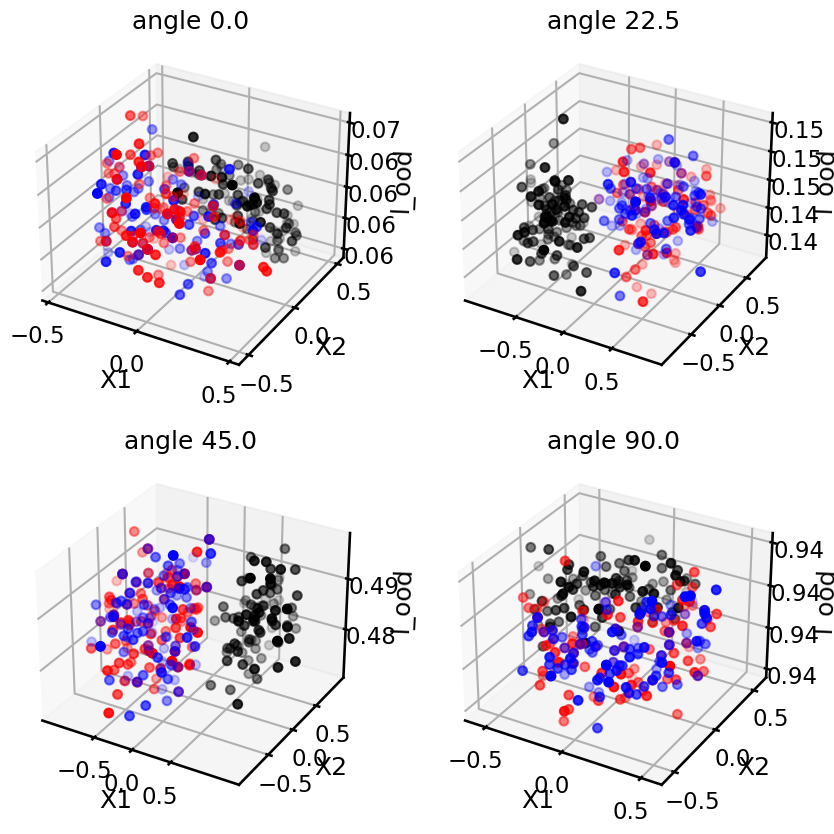

In [211]:
fig = plt.figure(figsize=(10,10))
sns.set_context('talk')

for ii, angle in enumerate(angles):
    ax = fig.add_subplot(2,2,ii+1, projection='3d')
    plot_embeddings(X_transformed[ii], l_id[ii], l_ood[ii], angle, ax)

plt.savefig('embeddings.pdf')

In [218]:
n_components = [1,2,3,4,5,6,7,8,9,10]
stresses = []

for component in tqdm(n_components):
    _, _, _, stress = experiment(np.pi/4, component, stress=True)
    stresses.append(stress)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [22:52<00:00, 137.26s/it]


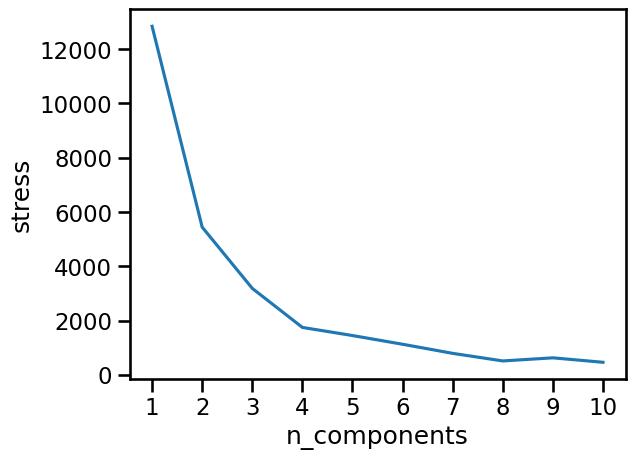

In [229]:
sns.set_context('talk')

plt.plot(n_components, stresses)
plt.xticks(n_components)
plt.xlabel('n_components')
plt.ylabel('stress')
plt.savefig('scree_plot.pdf', bbox_inches='tight')

In [230]:
import pickle

summary = (X_transformed, l_id, l_ood, stresses)

with open('result.pickle','wb') as f:
    pickle.dump(summary, f)

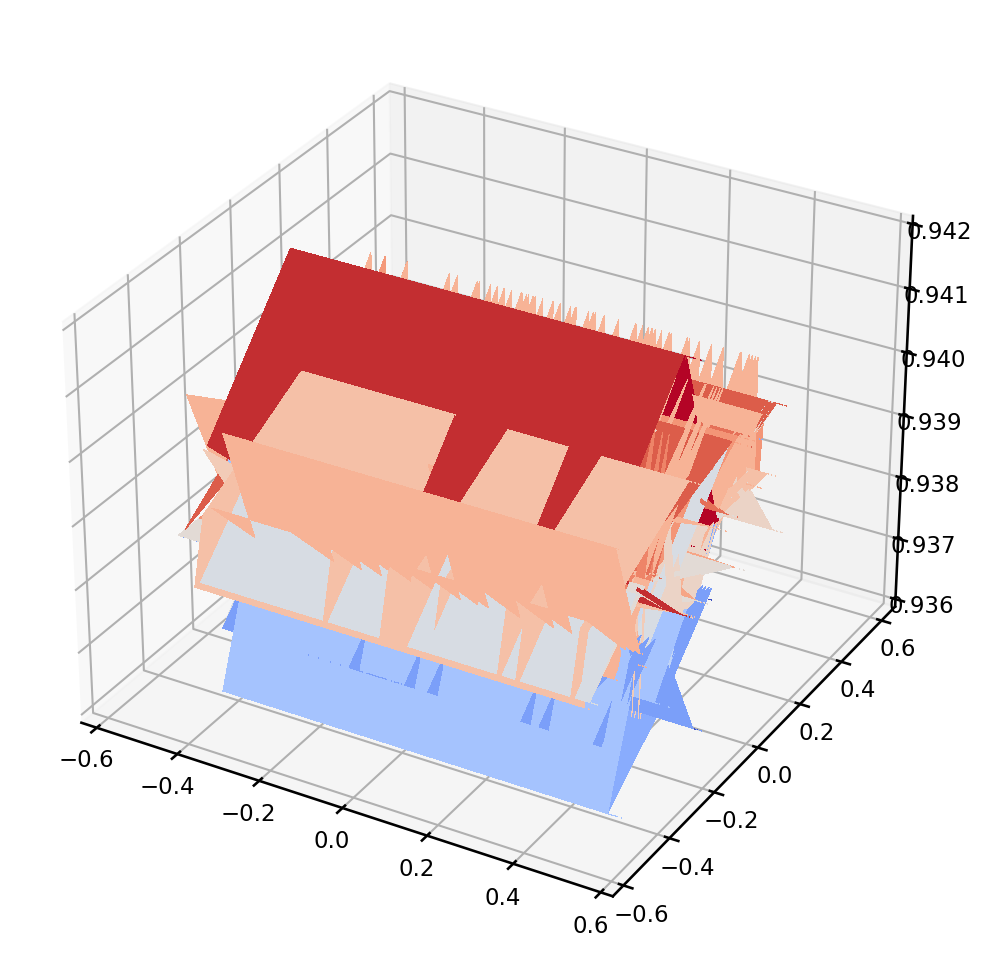

In [254]:
id = 3

fig = plt.figure(figsize=(10,10))
sns.set_context('talk')

ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(X_transformed[id][:100,0].reshape(1,-1), X_transformed[id][:100,1].reshape(1,-1), l_ood[id][0,:].reshape(1,-1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.plot_surface(X_transformed[id][100:200,0].reshape(1,-1), X_transformed[id][100:200,1].reshape(1,-1), l_ood[id][1,:].reshape(1,-1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.plot_surface(X_transformed[id][200:,0].reshape(100,1), X_transformed[id][200:,1].reshape(1,-1), l_ood[id][2,:].reshape(1,-1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.tight_layout()

In [394]:
def plot_embeddings_(X_transformed, l_id, l_ood, angle, ax):
    cmap1 = cm.Blues
    cmap2 = cm.Reds
    cmap3 = cm.Greens
    l_id[0,:] = (l_id[0,:] - np.min(l_id[0,:]))/(np.max(l_id[0,:]) - np.min(l_id[0,:]))
    l_id[1,:] = (l_id[1,:] - np.min(l_id[1,:]))/(np.max(l_id[1,:]) - np.min(l_id[1,:]))
    l_id[2,:] = (l_id[2,:] - np.min(l_id[2,:]))/(np.max(l_id[2,:]) - np.min(l_id[2,:]))
    
    ax.plot_surface(X_transformed[:100,0].reshape(10,10), X_transformed[:100,1].reshape(10,10), l_ood[0,:].reshape(10,10),
                           linewidth=0, antialiased=False, facecolors=cmap1(l_id[0,:].reshape(10,10)))
    ax.plot_surface(X_transformed[100:200,0].reshape(10,10), X_transformed[100:200,1].reshape(10,10), l_ood[1,:].reshape(10,10),
                           linewidth=0, antialiased=False, facecolors=cmap2(l_id[1,:].reshape(10,10)))
    ax.plot_surface(X_transformed[200:,0].reshape(10,10), X_transformed[200:,1].reshape(10,10), l_ood[2,:].reshape(10,10),
                           linewidth=0, antialiased=False, facecolors=cmap3(l_id[2,:].reshape(10,10)))

    
    ax.set_zlabel('l_ood')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.set_title('angle ' + str(np.round(angle*180/np.pi,1)))
    ax.set_xticks([-0.5,0,0.5])
    ax.set_yticks([-0.5,0,0.5])

    return ax

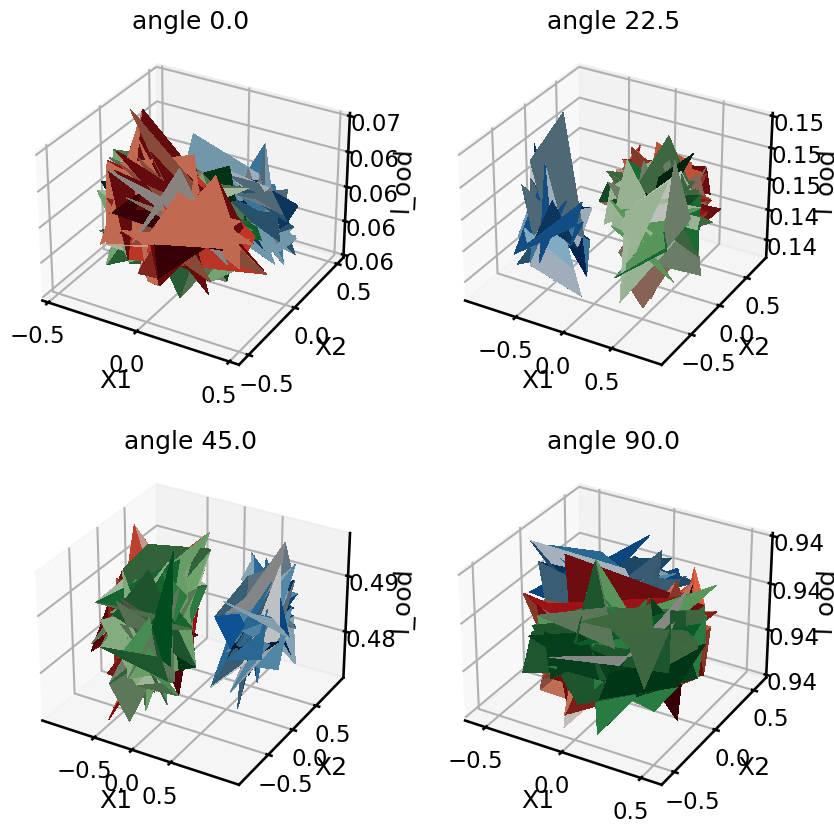

In [395]:
fig = plt.figure(figsize=(10,10), facecolor='white')
sns.set_context('talk')

for ii, angle in enumerate(angles):
    ax = fig.add_subplot(2,2,ii+1, projection='3d')
    surf = plot_embeddings_(X_transformed[ii], l_id[ii], l_ood[ii], angle, ax)
plt.savefig('embeddings_.pdf')

In [386]:
cm.jet(l_ood[0][0,:].reshape(-1,1)).shape

(100, 1, 4)

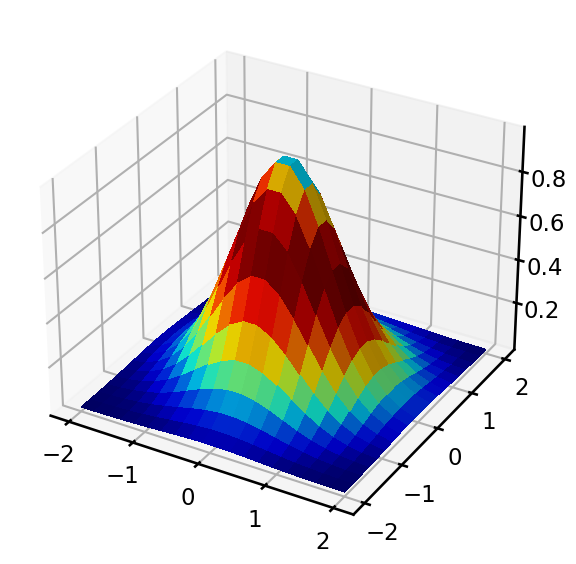

In [387]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-2, 2, 20)
y = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x, y)
h = np.exp(-X**2 - Y**2)            # plotted function
u = -2*X*np.exp(-X**2 - Y**2)       # speed in x-direction
v = -2*Y*np.exp(-X**2 - Y**2)       # speed in y-direction
c = np.sqrt(u**2 + v**2)            # colormap derives from this

fig = plt.figure(figsize = (8, 7), facecolor='white')
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, h, rstride=1, cstride=1, facecolors = cm.jet(c/np.amax(c)),
                       linewidth=0, antialiased=False)

plt.show()

In [318]:
cm.jet(c/np.amax(c)).shape

(20, 20, 4)

In [326]:
ii

0

IndexError: index 4 is out of bounds for axis 0 with size 4

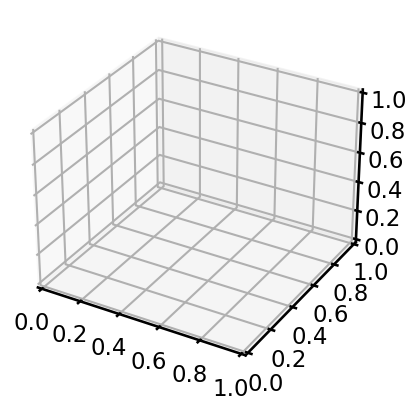

In [371]:
import matplotlib.pyplot as plt
import numpy as np

# Create a surface plot
x = np.linspace(-3, 3, 25)
y = np.linspace(-3, 3, 25)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) + np.cos(Y)

# Set the facecolors argument to a colormap
cmap = plt.cm.jet
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X[:,0], Y[0,:], Z[:,0].reshape(25,1), cmap=cmap, facecolors=cmap(Z[:,0]))

# Add a colorbar
#plt.colorbar(ax)

# Show the plot
plt.show()

In [372]:
cmap(Z[:,0]).shape

(25, 4)

In [363]:
Y[0,:].shape

(25,)

In [368]:
from matplotlib.colors import LightSource
light = LightSource(90, 45)

rgb = np.ones((Z.shape[0], Z.shape[1], 3))
illuminated_surface = light.shade_rgb(rgb, Z)

In [369]:
illuminated_surface.shape

(25, 25, 3)

In [370]:
Z.shape

(25, 25)